In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt 
import seaborn as sns  
from pathlib import PurePath
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

import warnings

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
warnings.filterwarnings('ignore')

%matplotlib inline

Could you please provide a description of the dataset and the source for it, if possible? He wants it to be part of my experimentation for automatically finding high-performing trend prediction models on time series using AutoML. The key characteristics for me are whether it is a time series, if it is non-stationary or stationary, if there are seasonal trends, if it has missing values, and if it is publicly available.

In [3]:
metr = pd.read_hdf(PurePath('../data/metr-la.h5'))
pems = pd.read_hdf(PurePath('../data/pems-bay.h5'))

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def plot_time(df, ids, dataset, start=0, end=12,):
    fig, ax = plt.subplots(figsize=(30, 10))
    for i in ids:
        ax.plot(df[i][start:end], label='Node ID: {}'.format(i))
    ax.legend()
    if start == 0:
        ax.set_title('Speeds Recorded for Nodes ({}, {}HRS)'.format(dataset, end//12))
    else:
         ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset))
    ax.set_ylabel('Speed')
    ax.set_xlabel('DateTime of Recording')
    plt.show()

In [6]:
def plot_time_moving_average(df, ids, dataset, start=0, end=12, plot_intervals=False, scale=1.96, window_size=12):
    fig, ax = plt.subplots(figsize=(30, 10))
    for i in ids:
        rolling_mean = df[i][start:end].rolling(window_size).mean()
        if plot_intervals:
            mae = mean_absolute_error(df[i][start+window_size:end], rolling_mean[window_size:])
            deviation = np.std(df[i][start+window_size:end] - rolling_mean[window_size:])
            lower_bound = rolling_mean - (mae + scale * deviation)
            upper_bound = rolling_mean + (mae + scale * deviation)
            ax.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
            ax.plot(lower_bound, 'r--')
        ax.plot(rolling_mean, label='Node ID: {} Rolling Mean'.format(i))
        ax.plot(df[i][start:end], label='Node ID: {} Real Values'.format(i))
    ax.legend()
    if start == 0:
        ax.set_title('Speeds Recorded for Nodes ({}, {}HRS) using Moving average size:{}'.format(dataset, end//window_size, window_size))
    else:
         ax.set_title('Speeds Recorded for Nodes ({}) using Moving average size:{}'.format(dataset, window_size))
    ax.set_ylabel('Speed')
    ax.set_xlabel('DateTime of Recording')
    plt.show()

In [7]:
def cleanDF(df):
    df.reset_index(inplace=True)
    df.set_index('index', inplace=True)
    df.index.rename('DateTime', inplace=True)
    return df

In [8]:
def adf_test(timeseries, node):
    print ('Results of Dickey-Fuller Test for Node {}:'.format(node))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if  dfoutput['p-value'] < 0.05 :
        print('Reject Null Hypothesis')
    else:
        print('Fail to Reject Null Hypothesis')
    print('\n')

In [9]:
def kpss_test(timeseries, node):
    print ('Results of KPSS Test for Node {}:'.format(node))
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if  kpss_output['p-value'] < 0.05 :
        print('Reject Null Hypothesis')
    else:
        print('Fail to Reject Null Hypothesis')
    print('\n')

In [10]:
def mean_variance_check(values, node): 
    print('Testing mean and variance for Node {}\n'.format(node))
    # getting the count to split the dataset into 3
    parts = int(len(values)/3)
    
    # splitting the data into three parts
    part_1, part_2, part_3 = values[0:parts], values[parts:(
        parts*2)], values[(parts*2):(parts*3)]
    
    # calculating the mean of the separated three
    # parts of data individually.
    mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()
    
    # calculating the variance of the separated
    # three parts of data individually.
    var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()
    
    # printing the mean of three groups
    print('mean_1 = %f\nmean_2 = %f\nmean_3 = %f' % (mean_1, mean_2, mean_3))
    
    # printing the variance of three groups
    print('variance_1 = %f\nvariance_2 = %f\nvariance_3 = %f' % (var_1, var_2, var_3))
    print('\n')

In [11]:
df_metr = cleanDF(metr)
df_pemsbay = cleanDF(pems)

# Checking for Null values in datasets

In [12]:
x= df_metr.values
np.argwhere(np.isnan(x))

array([], shape=(0, 2), dtype=int64)

In [13]:
y= df_pemsbay.values
np.argwhere(np.isnan(y))

array([], shape=(0, 2), dtype=int64)

# Performing tests for stationary and non-stationary data.


In [14]:
adf_test(df_metr['773869'], '773869')#[0:(288*3)])
adf_test(df_metr['767541'], '767541')
adf_test(df_metr['767542'], '767542')

Results of Dickey-Fuller Test for Node 773869:
Test Statistic                -1.200105e+01
p-value                        3.346036e-22
#Lags Used                     5.200000e+01
Number of Observations Used    3.421900e+04
Critical Value (1%)           -3.430541e+00
Critical Value (5%)           -2.861624e+00
Critical Value (10%)          -2.566815e+00
dtype: float64
Reject Null Hypothesis


Results of Dickey-Fuller Test for Node 767541:
Test Statistic                -1.300218e+01
p-value                        2.673162e-24
#Lags Used                     3.600000e+01
Number of Observations Used    3.423500e+04
Critical Value (1%)           -3.430541e+00
Critical Value (5%)           -2.861624e+00
Critical Value (10%)          -2.566815e+00
dtype: float64
Reject Null Hypothesis


Results of Dickey-Fuller Test for Node 767542:
Test Statistic                -1.379366e+01
p-value                        8.830922e-26
#Lags Used                     4.800000e+01
Number of Observations Used    

In [15]:
kpss_test(df_metr['773869'], '773869')
kpss_test(df_metr['767541'], '767541')
kpss_test(df_metr['767542'], '767542')

Results of KPSS Test for Node 773869:
Test Statistic             0.549694
p-value                    0.030474
#Lags Used               108.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Reject Null Hypothesis


Results of KPSS Test for Node 767541:
Test Statistic             0.208528
p-value                    0.100000
#Lags Used               108.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to Reject Null Hypothesis


Results of KPSS Test for Node 767542:
Test Statistic             0.172682
p-value                    0.100000
#Lags Used               108.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to Reject Null Hypothe

In [16]:
adf_test(df_pemsbay[400001], '400001')
adf_test(df_pemsbay[400017], '400017')
adf_test(df_pemsbay[400030], '400030')

Results of Dickey-Fuller Test for Node 400001:
Test Statistic                   -29.832882
p-value                            0.000000
#Lags Used                        30.000000
Number of Observations Used    52085.000000
Critical Value (1%)               -3.430476
Critical Value (5%)               -2.861595
Critical Value (10%)              -2.566800
dtype: float64
Reject Null Hypothesis


Results of Dickey-Fuller Test for Node 400017:
Test Statistic                   -24.055827
p-value                            0.000000
#Lags Used                        58.000000
Number of Observations Used    52057.000000
Critical Value (1%)               -3.430476
Critical Value (5%)               -2.861596
Critical Value (10%)              -2.566800
dtype: float64
Reject Null Hypothesis


Results of Dickey-Fuller Test for Node 400030:
Test Statistic                   -30.164108
p-value                            0.000000
#Lags Used                        18.000000
Number of Observations Used    

In [17]:
kpss_test(df_pemsbay[400001], '400001')
kpss_test(df_pemsbay[400017], '400017')
kpss_test(df_pemsbay[400030], '400030')

Results of KPSS Test for Node 400001:
Test Statistic             0.035949
p-value                    0.100000
#Lags Used               131.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to Reject Null Hypothesis


Results of KPSS Test for Node 400017:
Test Statistic             0.038118
p-value                    0.100000
#Lags Used               133.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to Reject Null Hypothesis


Results of KPSS Test for Node 400030:
Test Statistic             0.035659
p-value                    0.100000
#Lags Used               128.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Fail to Reject Null

In [18]:
mean_variance_check(df_metr['773869'], '773869')
mean_variance_check(df_metr['767541'], '767541')
mean_variance_check(df_metr['767542'], '767542')

Testing mean and variance for Node 773869

mean_1 = 54.293307
mean_2 = 59.229655
mean_3 = 50.371114
variance_1 = 542.035439
variance_2 = 276.248203
variance_3 = 677.278661


Testing mean and variance for Node 767541

mean_1 = 58.856745
mean_2 = 62.603340
mean_3 = 59.898281
variance_1 = 335.746102
variance_2 = 125.845613
variance_3 = 296.118175


Testing mean and variance for Node 767542

mean_1 = 59.235071
mean_2 = 62.648811
mean_3 = 60.294478
variance_1 = 408.403059
variance_2 = 217.841237
variance_3 = 373.844325




In [19]:
mean_variance_check(df_pemsbay[400001], '400001')
mean_variance_check(df_pemsbay[400017], '400017')
mean_variance_check(df_pemsbay[400030], '400030')

Testing mean and variance for Node 400001

mean_1 = 67.523854
mean_2 = 67.876911
mean_3 = 67.304904
variance_1 = 63.823225
variance_2 = 57.996654
variance_3 = 75.783082


Testing mean and variance for Node 400017

mean_1 = 59.016285
mean_2 = 59.471086
mean_3 = 58.569865
variance_1 = 178.492102
variance_2 = 160.398113
variance_3 = 187.425501


Testing mean and variance for Node 400030

mean_1 = 59.184849
mean_2 = 59.279052
mean_3 = 58.951831
variance_1 = 128.528313
variance_2 = 139.683049
variance_3 = 139.517247




# Checking for seasonality in random data samples. Also can be used to visually test for stationarity

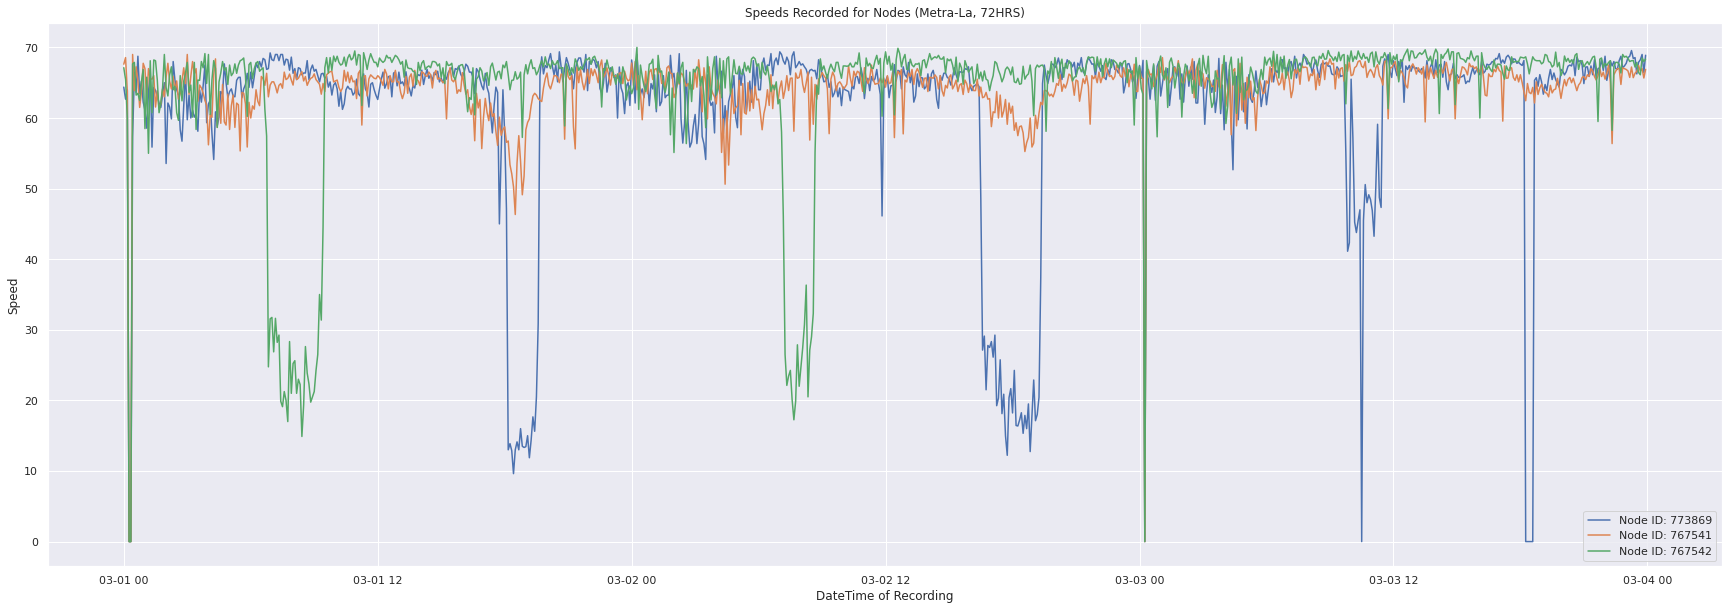

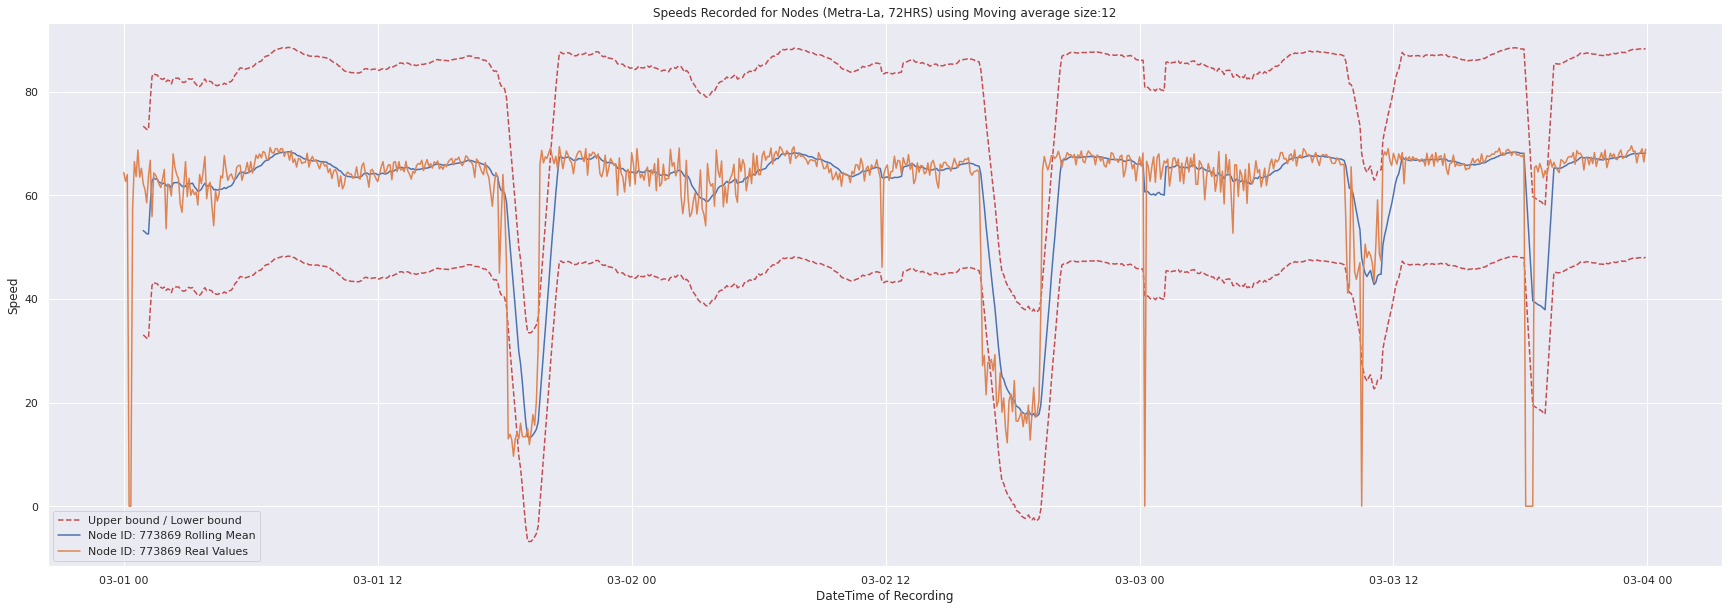

In [20]:
plot_time(df_metr,['773869', '767541' ,'767542'], 'Metra-La', end=(288*3)) #  24hrs=288*1, 48hrs=288*2, 72hrs=288*3
plot_time_moving_average(df_metr,['773869'], 'Metra-La', end=(288*3), plot_intervals=True,)

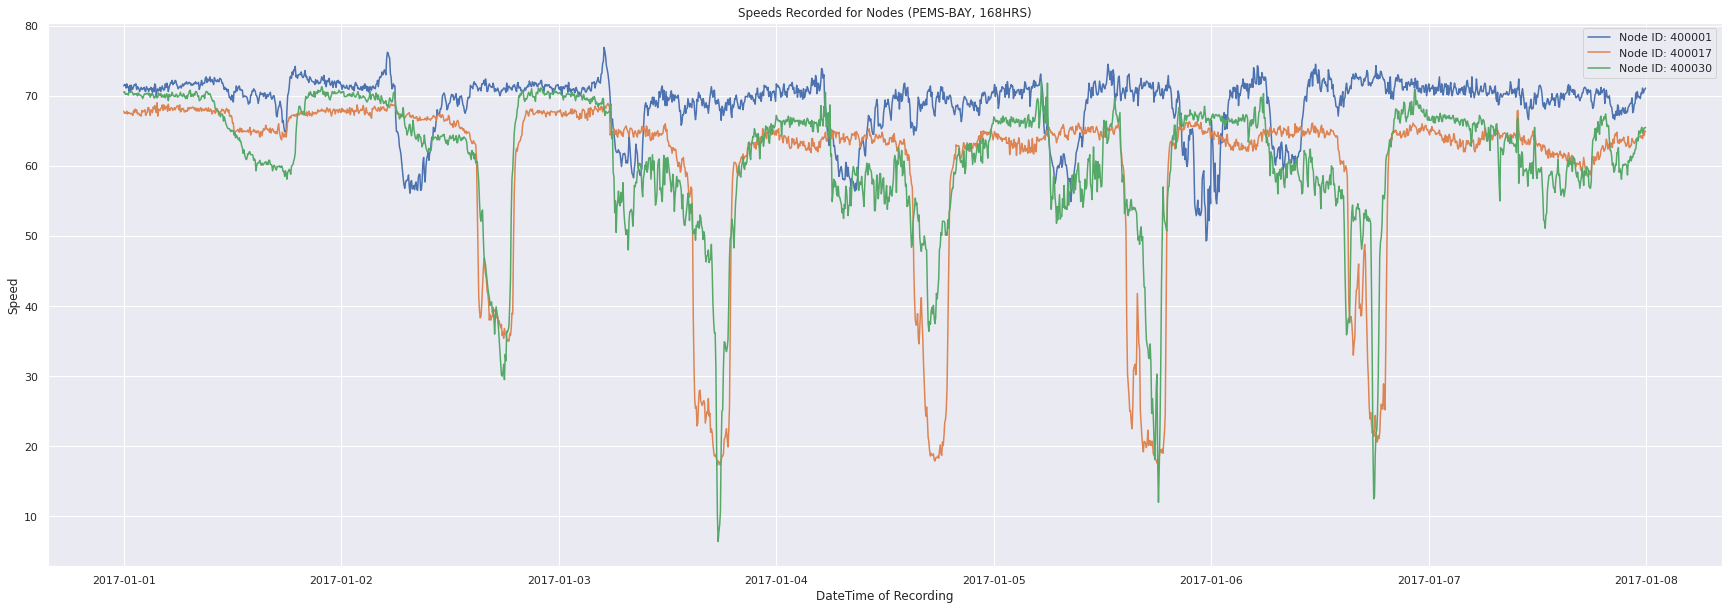

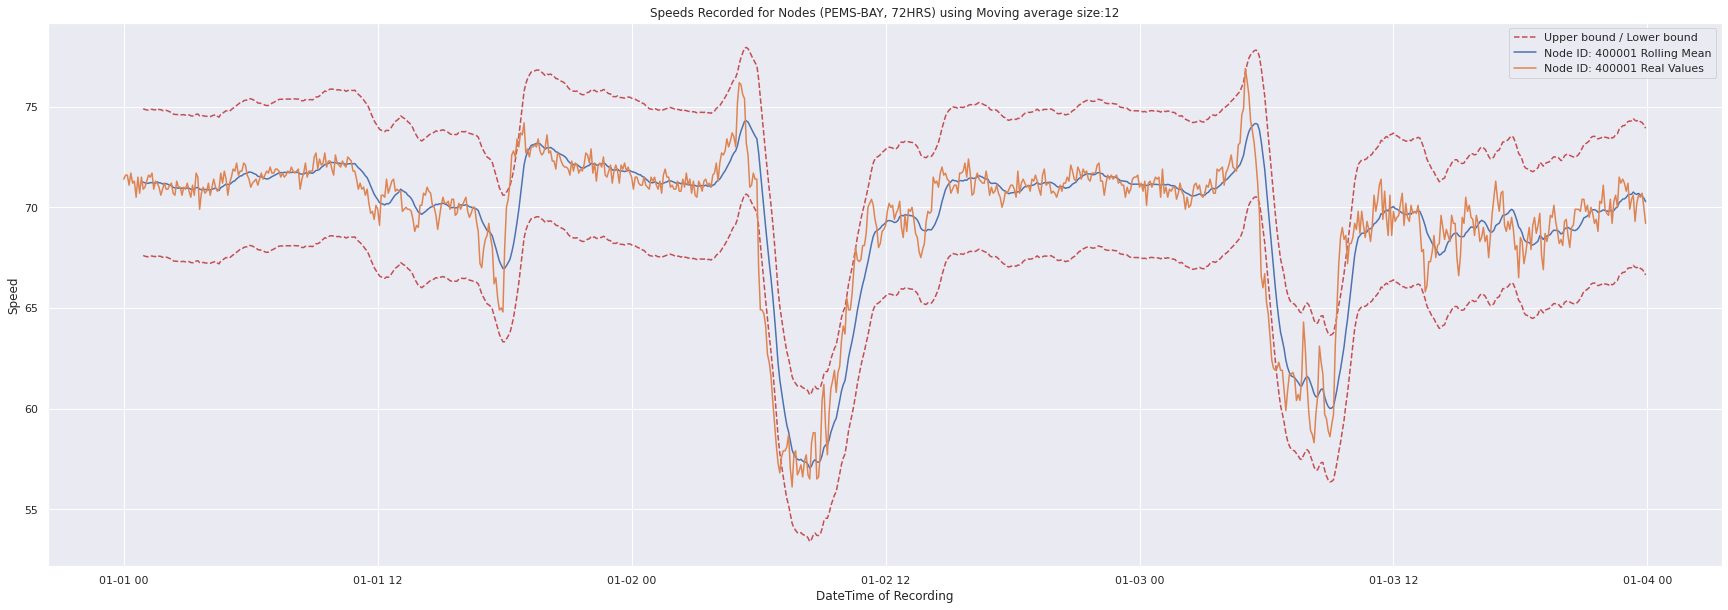

In [21]:
plot_time(df_pemsbay, [400001,400017, 400030], 'PEMS-BAY',  end=(288*7)) #  24hrs=288*1, 48hrs=288*2, 72hrs=288*3
plot_time_moving_average(df_pemsbay,[400001], 'PEMS-BAY', end=(288*3), plot_intervals=True)

<AxesSubplot:xlabel='DateTime'>

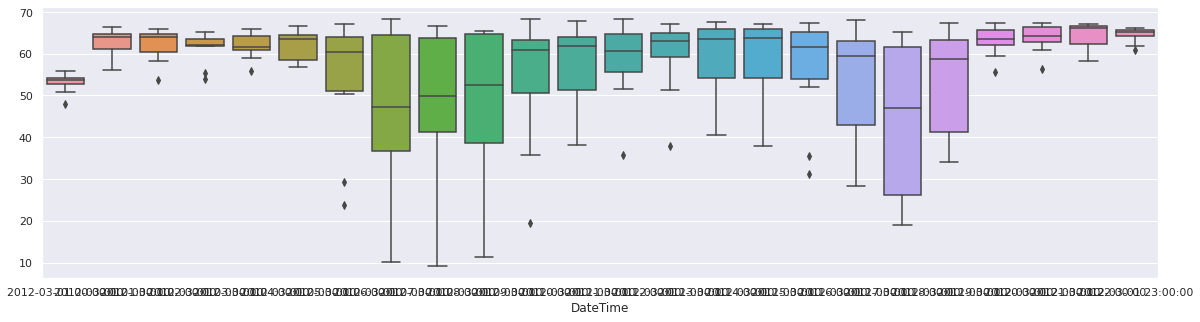

In [90]:
data = df_metr.resample('H').mean().iloc[:24, :10].transpose()
Fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=data)
# data
# print(data.index.hour)

# Summary

- Datasets do not contain any missing values.
- It can be noted that using the KPSS test the PEMS-BAY and METR-LA data for randomly selected nodes is seen to be non-stationary.
- However, when the ADF test is performed we can see that both datasets are seen to be stationary.
- Finally we partion each Node value by 3 and test the mean and variance of each node value. This method is not as reliable but we do see that the mean follows that of stationary data.
- From the above graphs we can clearly see some seasonality in the data as at specific times roughly the same amount of traffic speeds are seen.
- The datasets are publicly available and can be found on the following links [Google Drive](https://drive.google.com/open?id=10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX) or [Baidu Yun](https://pan.baidu.com/s/14Yy9isAIZYdU__OYEQGa_g) and [data/sensor_graph/graph_sensor_locations.csv](https://github.com/liyaguang/DCRNN/blob/master/data/sensor_graph/graph_sensor_locations.csv), and the loc as per the README file for the DCRNN model github repo.
